In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Flickr, Coauthor, CoraFull, Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

/home/bolt17/miniconda3/envs/StableVITON/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED=548
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import sklearn
sklearn.utils.check_random_state(SEED)
#-----------------------------------------
def edge_index_to_adj(edge_index, num_nodes):
    values = torch.ones(edge_index.shape[1])
    adj_matrix = torch.sparse_coo_tensor(edge_index, values, (num_nodes, num_nodes))
    return adj_matrix.to_dense()

dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]  # The dataset contains a single graph
print(data)
adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

features = torch.tensor(data.x)
# finding feature similarity across all the nodes via dot product
similarities = (features@features.T)

# making the diagnol elements to zero as the max similarity is obtained with a same
similarities = similarities * (torch.eye(len(similarities)) == 0).long()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/tmp/ipykernel_1926/1516843027.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


In [3]:
maxi=similarities.max()
# for i in range(similarities.shape[0]):
#     for j in range(similarities.shape[1]):
#         if similarities[i][j]>maxi:
#             maxi=similarities[i][j]
print(f"maximum cross similarity:{maxi}")

# normalizing similarty to lie in range [0,1]
similarities=torch.div(similarities, maxi)

alpha = 0.3
print(f"alpha:{alpha}")
max_similarities = (similarities > alpha).long()

new_edges = torch.nonzero(max_similarities, as_tuple=False).T
print(len(new_edges[1]))
existing_edges = set(map(tuple, data.edge_index.T.tolist()))

# check if there is a common edges between the ones we found and existing ones
filtered_new_edges = []
for i, j in new_edges.T.tolist():
    if (i, j) not in existing_edges and (j, i) not in existing_edges:  # Avoid duplicates
        filtered_new_edges.append([i, j])

# print(filtered_new_edges)

prev_edges = data.edge_index
if filtered_new_edges:
    filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T  # Shape: [2, num_new_edges]

    # Append new edges to data.edge_index

    data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)

print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")

new_edges = data.edge_index

print(f"previous_edges:{len(prev_edges[0])}")
print(f"new_edges:{len(new_edges[0])}")


maximum cross similarity:25.0
alpha:0.3
1650
Total new edges added: 1168
previous_edges:10556
new_edges:11724


In [4]:
save_edges = lambda args: pd.DataFrame(args[0].T).to_csv(args[1],index=None, header=None, sep=' ', mode='a')
def get_embeddings(
    edges, 
    edges_name="edgelist.txt", 
    k=128,  # Embedding dimension
    a=0.01,  # damping parameter
    partition=1,
    output=False
):
    '''
    "partition": the partition algorithm to use, default is 1.
    0: random bisection
    1: Louvain partition
    2: Louvain first-level partition
    3: Label Propagation partition
    '''
    open(edges_name,'w').close()
    save_edges((edges, edges_name))

    if not os.path.exists('./hierarchy.txt'):
        os.mknod('./hierarchy.txt')
    else:
        open('hierarchy.txt','w').close()
    if not os.path.exists('./vectors.txt'):
        os.mknod('./vectors.txt')
    else:
        open('vectors.txt','w').close()
    
    # do hierarchical clustering using Louvain algorithm
    endstr = '> /dev/null 2>&1'
    if(output):
        endstr = ''
    os.system(f'./LouvainNE/recpart ./{edges_name} ./hierarchy.txt {partition} {endstr}')
    
    # obtain node embedding of each node at every hierarchy
    os.system(f'./LouvainNE/hi2vec {k} {a} ./hierarchy.txt ./vectors.txt {endstr}')
    
    # Path to your output node embeddings text file
    file_path = 'vectors.txt'

    data_ = np.loadtxt(file_path)
    data_tensor = torch.from_numpy(data_)
    # The first column contains node IDs
    node_ids = data_tensor[:, 0].to(torch.int)
    # The remaining columns contain embeddings
    embeddings = data_tensor[:, 1:]
    return node_ids, embeddings

In [5]:
def evaluate_node_classification(aa_node_ids, aa_embeddings, data):
    """
    Evaluates multi-class node classification using Logistic Regression.

    Args:
        aa_node_ids: List of node IDs.
        aa_embeddings: Corresponding node embeddings.
        data: PyTorch Geometric data object containing labels and masks.

    Returns:
        Micro-F1 and Macro-F1 scores.
    """

    # Map node IDs to indices in embeddings
    node_to_idx = {node_id.item(): idx for idx, node_id in enumerate(aa_node_ids)}

    # Reorder embeddings to match the label ordering
    ordered_embeddings = np.zeros((len(data.y), aa_embeddings.shape[1]))
    for i in range(len(data.y)):
        ordered_embeddings[i] = aa_embeddings[node_to_idx[i]]

    # Convert masks to NumPy arrays
    train_mask = data.train_mask.numpy()
    test_mask = data.test_mask.numpy()

    # Prepare train and test data
    X_train, X_test = ordered_embeddings[train_mask], ordered_embeddings[test_mask]
    y_train, y_test = data.y[train_mask].numpy(), data.y[test_mask].numpy()

    # Train Logistic Regression classifier
    clf = LogisticRegression(max_iter=1000, solver='lbfgs')
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Compute Micro-F1 and Macro-F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    return {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1
    }


In [6]:
print('Only Initial Edges:')


a = []
b = []
for i in tqdm(range(16)):
    aa_node_ids, aa_embeddings = get_embeddings(prev_edges, "prev_edgelist.txt", k=256, partition=1)
    result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
    a.append(result['micro_f1'])
    b.append(result['macro_f1'])

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

print('Combined Edges:')
a = []
b = []
for i in tqdm(range(16)):
    aa_node_ids, aa_embeddings = get_embeddings(new_edges, "new_edgelist.txt", k=256, partition=1)
    result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
    a.append(result['micro_f1'])
    b.append(result['macro_f1'])

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

Only Initial Edges:


100%|██████████| 16/16 [00:02<00:00,  5.51it/s]


Micro-F1: 0.6865 ± 0.0147
Macro-F1: 0.6801 ± 0.0132
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

Micro-F1: 0.7489 ± 0.0077
Macro-F1: 0.7429 ± 0.0045


In [7]:
def evalator(alpha):
    
    dataset = Planetoid(root='data/Planetoid', name='Cora')
    data = dataset[0]  # The dataset contains a single graph
    print(data)
    adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

    features = torch.tensor(data.x)
    # finding feature similarity across all the nodes via dot product
    similarities = (features@features.T)

# making the diagnol elements to zero as the max similarity is obtained with a same
    similarities = similarities * (torch.eye(len(similarities)) == 0).long()
    
    maxi=similarities.max()

# normalizing similarty to lie in range [0,1]
    similarities=torch.div(similarities, maxi)
    
    max_similarities = (similarities > alpha).long()

    new_edges = torch.nonzero(max_similarities, as_tuple=False).T

    existing_edges = set(map(tuple, data.edge_index.T.tolist()))

    # check if there is a common edges between the ones we found and existing ones
    filtered_new_edges = []
    for i, j in new_edges.T.tolist():
        if (i, j) not in existing_edges and (j, i) not in existing_edges:  # Avoid duplicates
            filtered_new_edges.append([i, j])

    prev_edges = data.edge_index
    if filtered_new_edges:
        filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T  # Shape: [2, num_new_edges]

        # Append new edges to data.edge_index

        data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)

    print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")

    new_edges = data.edge_index


    a1 = []
    b1 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(prev_edges, "prev_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a1.append(result['micro_f1'])
        b1.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a1):.4f} ± {np.std(a1):.4f}")
    print(f"Macro-F1: {np.mean(b1):.4f} ± {np.std(b1):.4f}")

    print('Combined Edges:')
    a2 = []
    b2 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(new_edges, "new_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a2.append(result['micro_f1'])
        b2.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a2):.4f} ± {np.std(a2):.4f}")
    print(f"Macro-F1: {np.mean(b2):.4f} ± {np.std(b2):.4f}")
    
    return alpha,filtered_new_edges.shape[1],np.mean(a2),np.mean(b2),np.mean(a1),np.mean(b1)

In [13]:
evalator(0.3)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/tmp/ipykernel_6146/3194781479.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Total new edges added: 1168


100%|██████████| 16/16 [00:03<00:00,  5.04it/s]


Micro-F1: 0.6794 ± 0.0084
Macro-F1: 0.6765 ± 0.0081
Combined Edges:


100%|██████████| 16/16 [00:04<00:00,  3.26it/s]

Micro-F1: 0.7429 ± 0.0078
Macro-F1: 0.7413 ± 0.0055


(0.3,
 1168,
 0.7428750000000001,
 0.741331925179245,
 0.6794374999999999,
 0.6764971771789121)

In [9]:
x=[] #alpha
y1=[] # edge count added
y2=[] #micro
y3=[] #macro
y4=[]# micro
y5=[] # marcro
for alpha in range(0,10):
    alpha=alpha/20
    xx,y1a,y2b,y3c,y4d,y5e=evalator(alpha)
    x.append(xx)
    y1.append(y1a)
    y2.append(y2b)
    y3.append(y3c)
    y4.append(y4d)
    y5.append(y5e)
    

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/tmp/ipykernel_6146/3194781479.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Total new edges added: 4428556


100%|██████████| 16/16 [00:04<00:00,  3.93it/s]


Micro-F1: 0.6810 ± 0.0059
Macro-F1: 0.6766 ± 0.0049
Combined Edges:


100%|██████████| 16/16 [00:32<00:00,  2.03s/it]
/tmp/ipykernel_6146/3194781479.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.3260 ± 0.0000
Macro-F1: 0.2301 ± 0.0000
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Total new edges added: 2060336


100%|██████████| 16/16 [00:03<00:00,  4.82it/s]


Micro-F1: 0.6844 ± 0.0048
Macro-F1: 0.6810 ± 0.0053
Combined Edges:


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]
/tmp/ipykernel_6146/3194781479.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.4350 ± 0.0000
Macro-F1: 0.2901 ± 0.0000
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Total new edges added: 762060


100%|██████████| 16/16 [00:03<00:00,  4.18it/s]


Micro-F1: 0.6864 ± 0.0078
Macro-F1: 0.6806 ± 0.0062
Combined Edges:


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]
/tmp/ipykernel_6146/3194781479.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.4630 ± 0.0000
Macro-F1: 0.3059 ± 0.0000
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Total new edges added: 235376


100%|██████████| 16/16 [00:03<00:00,  4.07it/s]


Micro-F1: 0.6929 ± 0.0052
Macro-F1: 0.6866 ± 0.0039
Combined Edges:


100%|██████████| 16/16 [00:06<00:00,  2.63it/s]
/tmp/ipykernel_6146/3194781479.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.5640 ± 0.0060
Macro-F1: 0.4881 ± 0.0042
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Total new edges added: 16050


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Micro-F1: 0.6902 ± 0.0171
Macro-F1: 0.6842 ± 0.0128
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.98it/s]
/tmp/ipykernel_6146/3194781479.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6627 ± 0.0069
Macro-F1: 0.6386 ± 0.0052
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Total new edges added: 4122


100%|██████████| 16/16 [00:03<00:00,  4.84it/s]


Micro-F1: 0.6898 ± 0.0051
Macro-F1: 0.6863 ± 0.0043
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.31it/s]
/tmp/ipykernel_6146/3194781479.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.7132 ± 0.0126
Macro-F1: 0.7064 ± 0.0102
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Total new edges added: 1168


100%|██████████| 16/16 [00:03<00:00,  4.92it/s]


Micro-F1: 0.6834 ± 0.0096
Macro-F1: 0.6792 ± 0.0088
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.22it/s]
/tmp/ipykernel_6146/3194781479.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.7426 ± 0.0109
Macro-F1: 0.7383 ± 0.0084
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Total new edges added: 424


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Micro-F1: 0.6818 ± 0.0111
Macro-F1: 0.6791 ± 0.0096
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.92it/s]
/tmp/ipykernel_6146/3194781479.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6819 ± 0.0043
Macro-F1: 0.6754 ± 0.0042
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Total new edges added: 180


100%|██████████| 16/16 [00:03<00:00,  4.83it/s]


Micro-F1: 0.6899 ± 0.0062
Macro-F1: 0.6851 ± 0.0052
Combined Edges:


100%|██████████| 16/16 [00:04<00:00,  3.30it/s]
/tmp/ipykernel_6146/3194781479.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6701 ± 0.0042
Macro-F1: 0.6611 ± 0.0062
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Total new edges added: 146


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Micro-F1: 0.6908 ± 0.0030
Macro-F1: 0.6862 ± 0.0027
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.08it/s]

Micro-F1: 0.6729 ± 0.0076
Macro-F1: 0.6688 ± 0.0067


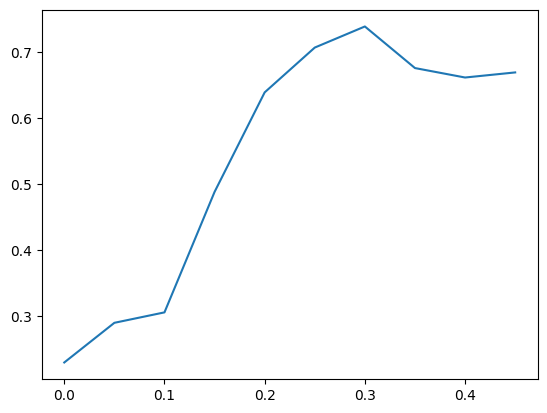

In [10]:
import matplotlib.pyplot as plt

plt.plot(x,y3)


In [11]:
print(y3)

[0.23013685575820353, 0.29011675569821976, 0.3058997448580994, 0.4880976070199906, 0.6386015293470235, 0.7063590290500916, 0.7382501694759915, 0.6753567260278439, 0.6610720046012725, 0.6687630617926342]


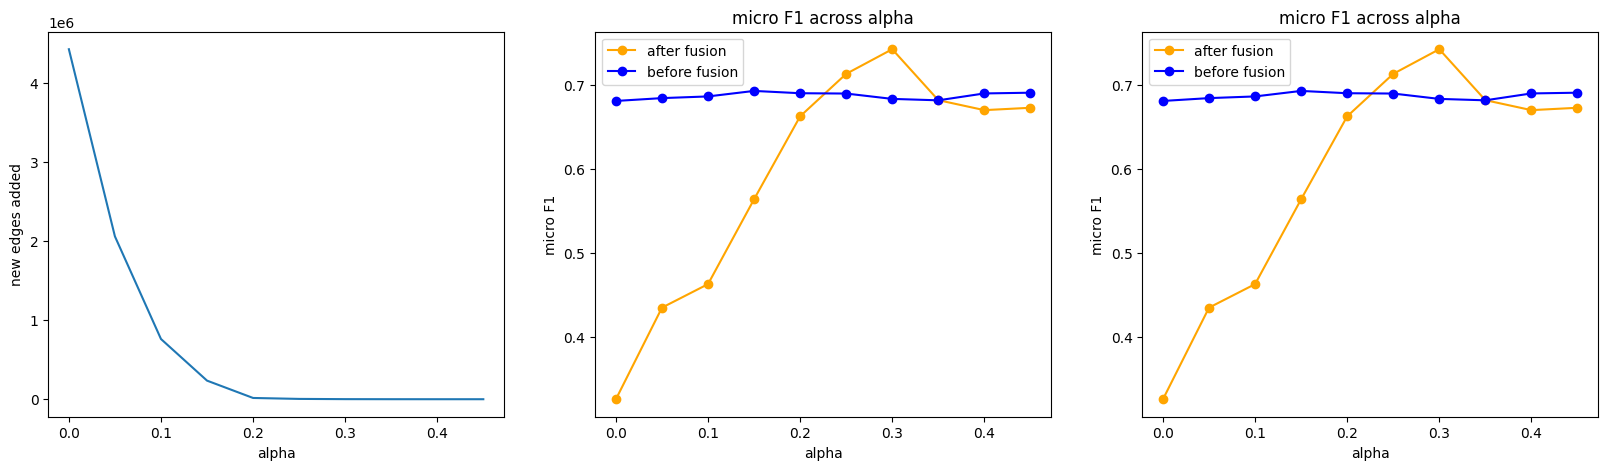

In [12]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(x,y1)
plt.xlabel('alpha')
plt.ylabel('new edges added')


plt.subplot(1,3,2)
plt.plot(x,y2,label="after fusion",marker="o",color="orange")
plt.plot(x,y4,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('micro F1')
plt.title('micro F1 across alpha')
plt.legend()


plt.subplot(1,3,3)
plt.plot(x,y2,label="after fusion",marker="o",color="orange")
plt.plot(x,y4,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('micro F1')
plt.title('micro F1 across alpha')
plt.legend()

plt.show()

